# Import Libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error

# Linear
from sklearn.linear_model import Lasso

# PCA
from sklearn.decomposition import PCA

# Trees
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# Import Data

In [22]:
data = pd.read_csv('./datasets/working_data/model_data_full.csv')

In [23]:
data.columns

Index(['intake_type', 'condition', 'age_in', 'breed', 'outcome', 'age_out',
       'sex', 'intact_out', 'age', 'primary_color', 'secondary_color',
       'breed_1', 'breed_2', 'pure', 'obey', 'reps_lower', 'reps_upper',
       'height_low_inches', 'height_high_inches', 'weight_low_lbs',
       'weight_high_lbs', 'time_in_shelter', 'date', 'month', 'at_risk',
       'cond', 'breed_3'],
      dtype='object')

In [24]:
data.head()

,intake_type,condition,age_in,breed,outcome,age_out,sex,intact_out,age,primary_color,...,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs,time_in_shelter,date,month,at_risk,cond,breed_3
0,surrender,normal,16.0,dachshund,adoption,16.0,1,0,senior,black,...,7.0,10.0,16.0,32.0,49,2013-10-03,10,1,NaN,dachshund
1,public_assist,aged,17.0,chihuahua,adoption,17.0,1,0,senior,tan,...,6.0,9.0,2.0,5.0,9,2016-09-28,9,0,NaN,chihuahua
2,stray,normal,15.0,labrador retriever/beagle,adoption,15.0,1,0,senior,sable,...,17.0,20.0,36.5,55.0,23,2015-10-06,10,1,NaN,labrador retriever
3,stray,normal,15.0,german shepherd,adoption,15.0,0,0,senior,black,...,22.0,26.0,75.0,90.0,89,2016-08-17,8,1,NaN,german shepherd
4,stray,normal,12.0,american eskimo,euthanasia,12.0,1,0,senior,cream,...,9.0,19.0,25.0,30.0,9,2014-08-27,8,0,NaN,other


# Set Target

In [25]:
y = data['time_in_shelter']
X = data.drop(columns=['time_in_shelter'])

# Train/Test Models

In [26]:
# option 1
numeric_cols = ['age_in', 'sex', 'intact_out', 'pure', 'obey', 'reps_lower', 'reps_upper', 'height_low_inches', 'height_high_inches', 'weight_low_lbs', 'weight_high_lbs']

In [27]:
# option 2
numeric_cols = ['age_in', 'obey', 'height_low_inches', 'height_high_inches', 'weight_low_lbs', 'weight_high_lbs']

In [28]:
cat_features = ['age']

In [29]:
X_dum = pd.concat([
    X[numeric_cols], 
    pd.get_dummies(X[cat_features]), 
    pd.get_dummies(X['breed_1']),
    # pd.get_dummies(X['primary_color'], prefix='color'), 
    pd.get_dummies(X['condition'], prefix='condition'), 
    # pd.get_dummies(X['intake_type'], prefix='intake')
    ], axis=1)

In [30]:
X_dum.head()

,age_in,obey,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs,age_adult,age_baby,age_senior,age_young,...,welsh terrier,west highland white terrier,whippet,yorkshire terrier,condition_aged,condition_behavior,condition_injured,condition_normal,condition_nursing,condition_other
0,16.0,0.500000,7.0,10.0,16.0,32.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,17.0,0.300000,6.0,9.0,2.0,5.0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,15.0,0.525000,17.0,20.0,36.5,55.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,15.0,0.950000,22.0,26.0,75.0,90.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,12.0,0.569858,9.0,19.0,25.0,30.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
X_dum.shape

(11599, 134)

Add feature interaction

In [32]:
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X_dum)

In [33]:
# with poly
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, random_state=123)

In [34]:
# without poly
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, random_state=123)

Scale data

In [35]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Linear Regression with L1

In [36]:
lr_params = {
    'alpha': [.05, .1, .25, .5],
}

lr = Lasso(random_state=123, max_iter=10_000)
gs_lr = GridSearchCV(lr, lr_params)

gs_lr.fit(X_train_sc, y_train)

GridSearchCV(estimator=Lasso(max_iter=10000, random_state=123),
             param_grid={'alpha': [0.05, 0.1, 0.25, 0.5]})

In [37]:
pd.DataFrame(gs_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.136027,0.037513,0.001152,0.000117,0.05,{'alpha': 0.05},0.065786,0.058759,0.069443,0.042520,0.074288,0.062159,0.011051,4
1,0.069464,0.007635,0.001021,0.000196,0.1,{'alpha': 0.1},0.067416,0.059961,0.070785,0.045124,0.075296,0.063716,0.010559,3
2,0.052193,0.009225,0.001114,0.000231,0.25,{'alpha': 0.25},0.069773,0.062330,0.071508,0.049413,0.075310,0.065667,0.009157,1
3,0.038158,0.003658,0.000990,0.000131,0.5,{'alpha': 0.5},0.071012,0.061504,0.069128,0.051010,0.072101,0.064951,0.007894,2


In [38]:
# Score on training and testing sets.
print(f'Training Score: {round(gs_lr.score(X_train_sc, y_train),4)}')
print(f'Testing Score: {round(gs_lr.score(X_test_sc, y_test),4)}')

Training Score: 0.0806
Testing Score: 0.0691


Explained only 7% of the variance. Yikes... Not looking good.

In [39]:
np.round(mean_squared_error(y_test, gs_lr.predict(X_test_sc), squared=False), 2)

34.25

Baseline in days

In [40]:
np.round(y.mean(), 2)

37.32

Not getting any signal!! Will try to reduce the number of features. Will try PCA, but doubtful the scores improve by much, if at all. There are a lot of dummy features in the sparse matrix. Its possible the less frequent breeds could be adding some noise.

# PCA

In [41]:
X_dum = pd.concat([
    X[numeric_cols], 
    pd.get_dummies(X[cat_features]), 
    pd.get_dummies(X['breed_1']),
    # pd.get_dummies(X['primary_color'], prefix='color'), 
    pd.get_dummies(X['condition'], prefix='condition'), 
    # pd.get_dummies(X['intake_type'], prefix='intake')
    ], axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, random_state=12)

In [43]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [44]:
pca = PCA(random_state=123, n_components=50)
pca.fit(X_train_sc)

PCA(n_components=50, random_state=123)

In [45]:
Z_train = pca.transform(X_train_sc)
Z_test = pca.transform(X_test_sc)
pd.DataFrame(Z_train)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-4.260833,-0.844718,-1.782774,0.426147,0.666113,1.109201,0.590163,-0.922023,0.433890,-0.178727,...,0.018663,0.005242,0.004897,-0.005862,0.002817,0.000669,0.005800,0.008338,-0.012759,0.008360
1,-0.288654,1.086075,-0.440950,0.282274,-1.646856,-0.616418,-0.790909,0.326844,-0.447124,0.820573,...,-0.003963,0.002985,0.001262,0.006146,-0.000783,-0.000412,0.002124,-0.000273,-0.005623,0.001724
2,0.157039,-4.103967,2.181377,-1.734093,-0.442277,-0.814122,-1.843662,0.704937,0.473577,-0.909234,...,-0.015381,0.030619,0.041939,0.023770,-0.017514,-0.009946,0.015823,0.006018,-0.037729,-0.011572
3,-0.863515,-1.570414,1.372937,2.498154,-1.520231,2.725537,-0.350836,0.031351,-0.541314,0.847283,...,-0.020348,-0.002815,0.014485,-0.002266,0.006520,0.001948,0.009610,-0.006126,0.001396,-0.002883
4,-0.356838,1.459821,-0.189032,0.180535,-1.573982,-0.565135,-0.811289,0.332363,-0.476418,0.826765,...,-0.008102,0.006068,0.004854,0.004558,0.002234,-0.000273,0.000077,-0.001990,-0.004321,-0.000176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,0.719211,-1.570738,-0.963899,0.121145,1.638817,-1.249999,0.127234,1.537255,-0.590412,-0.111243,...,0.138783,-0.044628,-0.060947,-0.023958,0.005943,-0.005379,-0.022026,-0.021002,0.006294,-0.059500
8695,-0.046983,-0.059264,-1.554327,0.248962,-0.824963,1.552465,-0.956768,0.153879,-0.304074,0.991946,...,-0.006180,0.003391,0.004448,-0.000998,-0.000778,0.000212,0.002993,0.005513,-0.007542,-0.000851
8696,-4.293898,-1.663809,-0.993527,-0.209011,1.217724,-1.049496,0.420298,-0.606620,0.217882,-0.159736,...,0.018976,0.003642,-0.003446,-0.003568,0.004537,-0.001521,0.004699,0.003267,-0.016470,0.005689
8697,1.115005,-1.205242,-0.345138,0.403440,1.021139,-1.142332,0.532097,1.045925,-0.715993,-1.305493,...,0.014607,-0.011635,-0.040137,-0.129827,0.019664,-0.002998,-0.038178,-0.061830,-0.087020,-0.020030


In [46]:
np.round(pca.explained_variance_ratio_, 4)

array([0.0398, 0.0176, 0.015 , 0.0124, 0.0116, 0.0113, 0.0085, 0.0085,
       0.0084, 0.0083, 0.0079, 0.0078, 0.0078, 0.0077, 0.0077, 0.0076,
       0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076, 0.0076,
       0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
       0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
       0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075,
       0.0075, 0.0075])

In [47]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 10 components): {np.round(var_exp[:10], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 10 components): {np.round(var_exp[:10], 3)}')

Explained variance (first 10 components): [0.04  0.018 0.015 0.012 0.012 0.011 0.009 0.008 0.008 0.008]

Cumulative explained variance (first 10 components): [0.04  0.018 0.015 0.012 0.012 0.011 0.009 0.008 0.008 0.008]


In [48]:
## Set up dataframe with PCs and amount of explained variance
columns = [f'PCA_{i+1}' for i in pd.DataFrame(Z_train).columns]
var_ratio_df = pd.DataFrame({
    'Variation':var_exp,
    'PC':columns
})

var_ratio_df.head()

,Variation,PC
0,0.039775,PCA_1
1,0.017637,PCA_2
2,0.015015,PCA_3
3,0.012364,PCA_4
4,0.011572,PCA_5


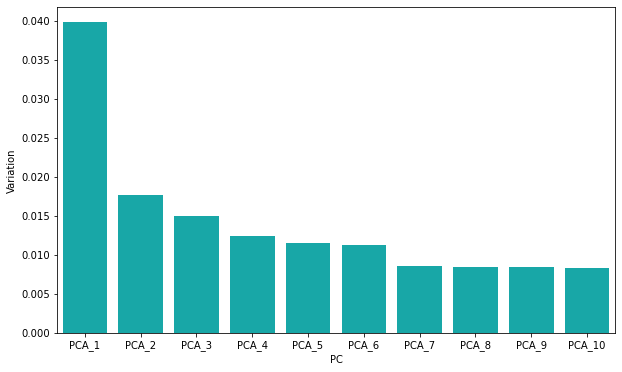

In [49]:
# Plot explained variance of each principal component
plt.figure(figsize = (10,6))
sns.barplot(x = var_ratio_df['PC'].head(10),
            y = var_ratio_df['Variation'].head(10), 
            data=var_ratio_df, color="c");

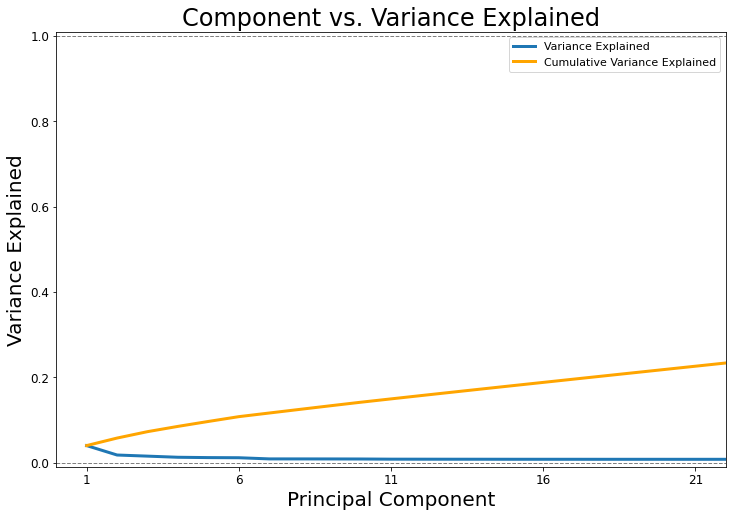

In [50]:
# Plot the variance explained (and cumulative variance explained).
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,21])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 21, 5), range(1, 22, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

In [51]:
pca_lr = Lasso().fit(Z_train, y_train)

print(f'Training RMSE: {round(pca_lr.score(Z_train, y_train),4)}')
print(f'Testing RMSE: {round(pca_lr.score(Z_test, y_test),4)}')

Training RMSE: 0.0534
Testing RMSE: 0.0355


In [52]:
mean_squared_error(y_test, pca_lr.predict(Z_test), squared=False)

36.00619113066033

Original model did not capture enough signal for PCA to be effective. Scrap it and move in a new direction. Lets try trees. Trying trees next.

# Decision Trees

In [39]:
rf = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=123, min_samples_split=100)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_split=100, random_state=123)

In [40]:
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))
print(mean_squared_error(y_test, rf.predict(X_test), squared=False))

0.1789138446125459
0.13925587998266187
27.24280988680873


In [41]:
tree = DecisionTreeRegressor(max_depth=5)

In [42]:
tree.fit(X_train, y_train)
print(tree.score(X_train, y_train))
print(tree.score(X_test, y_test))

0.13264800709942215
0.10139553979115845


Able to capture slightly more variance than linear regression! Not a lot of signal in the data. We're mostly dealing with categorical features, so lets try converting this problem into a classification problem.

[Run Next](https://github.com/gwoodstock/project4/blob/main/7_models_classification_trees.ipynb): Classification Models.